<a href="https://colab.research.google.com/github/Dhanush-adk/intro_to_dl/blob/main/Assignment_2/Assignment_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from tqdm.notebook import tqdm
import seaborn as sns



torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:05<00:00, 28476470.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [5]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [6]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [7]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])


In [8]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs = 20):
    if not train_loader or not test_loader:
        print("Empty data loaders. Exiting.")
        return None

    def calculate_metrics(predictions, targets):
        accuracy = 100 * sum([p == t for p, t in zip(predictions, targets)]) / len(targets)
        precision = precision_score(targets, predictions, average='weighted')
        recall = recall_score(targets, predictions, average='weighted')
        f1 = f1_score(targets, predictions, average='weighted')
        return accuracy, precision, recall, f1

    model.to(device)

    train_loss_list, val_loss_list, val_accuracy_list = [], [], []

    # Training loop
    epochs = n_epochs
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(train_loader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        all_predictions, all_targets = [], []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.tolist())
                all_targets.extend(labels.tolist())

        val_loss_list.append(running_loss / len(test_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Final evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())

    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_targets)

    # Print the metrics
    print(f'\nFinal Evaluation Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Return metrics
    return {
        'train_loss': train_loss_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'final_accuracy': accuracy,
        'final_precision': precision,
        'final_recall': recall,
        'final_f1': f1,
        'all_targets': all_targets,
        'all_predictions': all_predictions,
        'model': model
    }

In [26]:
class AlexNet(nn.Module):
    def __init__(self, dropout_p):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()  # Change variable name to avoid conflict
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_p)

        self.conv2 = nn.Conv2d(32, 96, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 4 * 4, 4096)  # Adjusted input size based on previous layers
        self.relu6 = nn.ReLU()

        self.fc2 = nn.Linear(4096, 1024)
        self.relu7 = nn.ReLU()

        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
os.chdir('/content/drive/MyDrive/ADKs_files')

In [14]:
model = AlexNet(dropout_p=0)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
print(model)

AlexNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (conv2): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (relu7): R

In [39]:
model_without_dropout = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)

Epoch 1, Training loss: 1.8120, Validation loss: 1.6070, Validation Accuracy: 40.63%
Epoch 2, Training loss: 1.5367, Validation loss: 1.5160, Validation Accuracy: 44.58%
Epoch 3, Training loss: 1.3828, Validation loss: 1.3830, Validation Accuracy: 49.08%
Epoch 4, Training loss: 1.2652, Validation loss: 1.2186, Validation Accuracy: 55.53%
Epoch 5, Training loss: 1.1454, Validation loss: 1.2340, Validation Accuracy: 57.56%
Epoch 6, Training loss: 1.0338, Validation loss: 1.1135, Validation Accuracy: 58.97%
Epoch 7, Training loss: 0.9430, Validation loss: 0.9939, Validation Accuracy: 64.83%
Epoch 8, Training loss: 0.8586, Validation loss: 0.9047, Validation Accuracy: 68.21%
Epoch 9, Training loss: 0.7810, Validation loss: 0.8407, Validation Accuracy: 70.88%
Epoch 10, Training loss: 0.7129, Validation loss: 0.9134, Validation Accuracy: 68.70%
Epoch 11, Training loss: 0.6432, Validation loss: 0.7565, Validation Accuracy: 73.96%
Epoch 12, Training loss: 0.5772, Validation loss: 0.7347, Valid

In [40]:
torch.save(model_without_dropout['model'].state_dict(), 'alexnetmodel_without_dropout.pth')

<Figure size 1000x800 with 0 Axes>

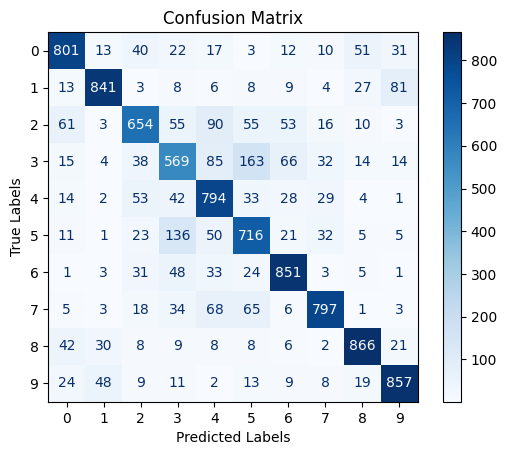

In [41]:
cm = confusion_matrix(model_without_dropout['all_targets'], model_without_dropout['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [42]:
total_params = sum(p.numel() for p in model_without_dropout['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 13161898


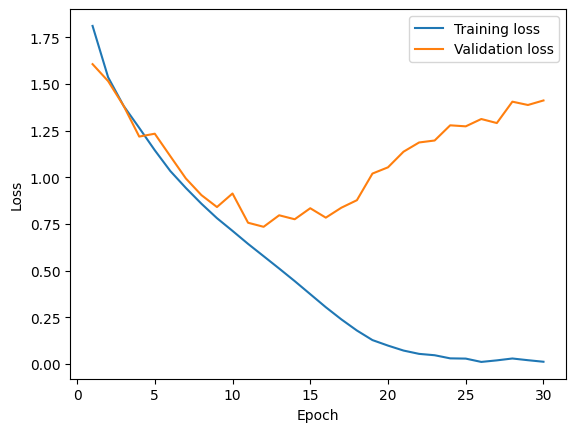

In [43]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_without_dropout['train_loss'], label='Training loss')
plt.plot(epochs_list, model_without_dropout['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model_with_dropout = AlexNet(dropout_p=0.50)
model_with_dropout = model_with_dropout.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01)

In [28]:
print(model_with_dropout)

AlexNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (relu7):

In [21]:
model_with_dropout_metrics = train_and_evaluate_model(model_with_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)

Epoch 1, Training loss: 2.3005, Validation loss: 2.2975, Validation Accuracy: 10.08%
Epoch 2, Training loss: 2.1489, Validation loss: 1.8988, Validation Accuracy: 29.87%
Epoch 3, Training loss: 1.8089, Validation loss: 1.7138, Validation Accuracy: 35.59%
Epoch 4, Training loss: 1.6786, Validation loss: 1.5906, Validation Accuracy: 41.03%
Epoch 5, Training loss: 1.5969, Validation loss: 1.5397, Validation Accuracy: 43.28%
Epoch 6, Training loss: 1.5174, Validation loss: 1.5223, Validation Accuracy: 44.01%
Epoch 7, Training loss: 1.4524, Validation loss: 1.4256, Validation Accuracy: 47.76%
Epoch 8, Training loss: 1.3955, Validation loss: 1.4084, Validation Accuracy: 48.05%
Epoch 9, Training loss: 1.3486, Validation loss: 1.3332, Validation Accuracy: 51.86%
Epoch 10, Training loss: 1.2985, Validation loss: 1.3165, Validation Accuracy: 52.42%
Epoch 11, Training loss: 1.2554, Validation loss: 1.2769, Validation Accuracy: 53.96%
Epoch 12, Training loss: 1.2174, Validation loss: 1.2138, Valid

In [22]:
torch.save(model_with_dropout_metrics['model'].state_dict(), 'alexnetmodel_with_dropout.pth')

<Figure size 1000x800 with 0 Axes>

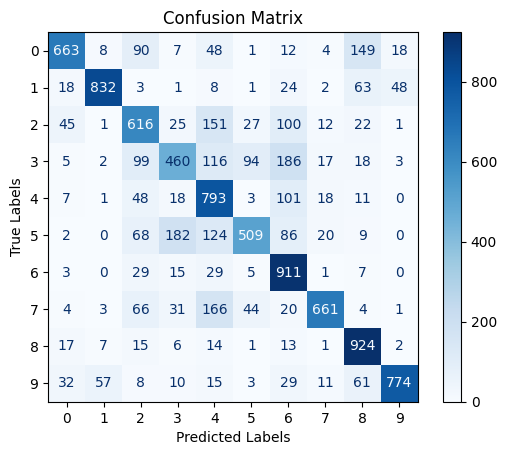

In [23]:
cm = confusion_matrix(model_with_dropout_metrics['all_targets'], model_with_dropout_metrics['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [24]:
total_params = sum(p.numel() for p in model_with_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 13161898


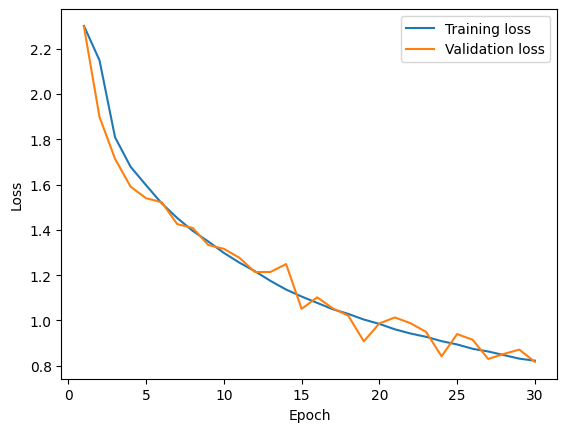

In [25]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_with_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_with_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()